In [1]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.12f' % x)

In [171]:
# REUTERS India Gov Benchmark data as of 09 Jan 2023
df = pd.DataFrame(
    {'maturity': [
'06.04.2023','06.07.2023','29.11.2023','15.06.2025','12.04.2026','15.11.2026','20.06.2027','18.04.2029',
'26.12.2029','03.08.2030','17.01.2032','22.08.2032','10.11.2033','16.06.2035','23.05.2036','19.12.2036',
'19.01.2039','12.12.2041','10.10.2046','12.09.2052','19.09.2062'],
        'coupon': [0,0,4.56,5.22,5.63,5.74,7.38,7.1,6.79,5.77,6.54,7.26,8.24,6.64,7.54,7.41,6.83,8.83,7.06,7.36,7.4],
     'px': [98.519,96.817,97.98,96.07,95.76,95.23,100.61,98.90,97.15,91.20,94.63,99.43,106.37,
            94.00,101.10,100.04,94.63,114.03,96.52,99.25,99.70],
    'issue': [
'05.01.2023','05.01.2023','29.11.2021','15.06.2020','12.04.2021','15.11.2021','20.06.2022','18.04.2022',
'26.12.2016','03.08.2020','17.01.2022','22.08.2022','10.11.2014','12.04.2021','23.05.2022','19.12.2022',
'19.01.2009','12.12.2011','10.10.2016','12.09.2022','19.09.2022']})

df

,maturity,coupon,px,issue
0,06.04.2023,0.000000000000,98.519000000000,05.01.2023
1,06.07.2023,0.000000000000,96.817000000000,05.01.2023
2,29.11.2023,4.560000000000,97.980000000000,29.11.2021
3,15.06.2025,5.220000000000,96.070000000000,15.06.2020
4,12.04.2026,5.630000000000,95.760000000000,12.04.2021
5,15.11.2026,5.740000000000,95.230000000000,15.11.2021
6,20.06.2027,7.380000000000,100.610000000000,20.06.2022
7,18.04.2029,7.100000000000,98.900000000000,18.04.2022
8,26.12.2029,6.790000000000,97.150000000000,26.12.2016
9,03.08.2030,5.770000000000,91.200000000000,03.08.2020


In [172]:
calendar = ql.India((ql.India.NSE))
valuationDate = ql.Date(9, 1, 2023)
ql.Settings.instance().evaluationDate = valuationDate
dc_tbill = ql.Actual365Fixed()
dc_bond = ql.Thirty360(ql.Thirty360.ISMA)
accrualConvention = ql.ModifiedFollowing
businessConvention = ql.ModifiedFollowing
couponFrequencyS = ql.Semiannual
couponFrequencyA = ql.Once
redemption = 100.0
settlementDays = 1
settlementDate = calendar.advance(valuationDate,ql.Period(settlementDays, ql.Days),ql.ModifiedFollowing,False)
end_of_month = True
valuationDate

Date(9,1,2023)

In [173]:
bills = []
bonds = []
for idx, row in df.iterrows():
    if row['coupon'] == 0:
        maturity = ql.Date(row.maturity, '%d.%m.%Y')
        issue = ql.Date(row.issue, '%d.%m.%Y')
        schedule = ql.Schedule(
           valuationDate,
            maturity,
            ql.Period(couponFrequencyA),
            calendar,
            accrualConvention,
            accrualConvention,
            ql.DateGeneration.Backward,
            end_of_month)
        helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(row.px)),
                settlementDays,
                100.0,
                schedule,
                [row.coupon / 100],
                dc_tbill,
                businessConvention,
                redemption)

        bills.append(helper)
    else:
        maturity = ql.Date(row.maturity, '%d.%m.%Y')
        issue = ql.Date(row.issue, '%d.%m.%Y')
        schedule = ql.Schedule(
            valuationDate, 
            maturity,
            ql.Period(couponFrequencyS),
            calendar,
            accrualConvention,
            accrualConvention,
            ql.DateGeneration.Backward,
            end_of_month)
        helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(row.px)),
                settlementDays,
                100.0,
                schedule,
                [row.coupon / 100],
                dc_bond,
                businessConvention,
                redemption)
        bonds.append(helper)
rateHelpers = bills + bonds

In [174]:
linear = ql.PiecewiseLinearZero(valuationDate, rateHelpers, dc_bond)
linear.enableExtrapolation()
linear_handle = ql.YieldTermStructureHandle(linear)

cubic = ql.PiecewiseCubicZero(valuationDate, rateHelpers, dc_bond)
cubic.enableExtrapolation()
cubic_handle = ql.YieldTermStructureHandle(cubic)

params = [valuationDate, rateHelpers, dc_bond]
fittingMethods = {
    'NelsonSiegelFitting': ql.NelsonSiegelFitting(),
    'SvenssonFitting': ql.SvenssonFitting()}

accuracy=1e-10
numIter = 100000
guess = []

fittedBondCurveMethods = {
                                                                            
    label: ql.FittedBondDiscountCurve(*params, method,accuracy,numIter,guess)#, 1)
    for label, method in fittingMethods.items()
}
 
curve_NS = fittedBondCurveMethods.get('NelsonSiegelFitting')
curve_NSS = fittedBondCurveMethods.get('SvenssonFitting')
curve_NS.enableExtrapolation()
curve_NSS.enableExtrapolation()
NS_handle = ql.YieldTermStructureHandle(curve_NS)
NSS_handle = ql.YieldTermStructureHandle(curve_NSS)

In [175]:
df_calc  = df
l_calc = []
c_calc = []
ns_calc = []
nss_calc = []
for idx,row in df.iterrows():
        tenor = ql.Period(ql.Semiannual)
        calendar = ql.India(ql.India.NSE)    
        schedule = ql.Schedule(valuationDate,
                               ql.Date(row.maturity, '%d.%m.%Y'),
                               tenor,
                               calendar,
                    ql.ModifiedFollowing,
                    ql.ModifiedFollowing, 
                   ql.DateGeneration.Backward, 
                   end_of_month)
        bond = ql.FixedRateBond(1, 100.0, schedule, [row.coupon/100], dc_bond,ql.ModifiedFollowing,100.0)
        bond.setPricingEngine(ql.DiscountingBondEngine(linear_handle))
        l_calc.append(bond.cleanPrice())
        bond = ql.FixedRateBond(1, 100.0, schedule, [row.coupon/100], dc_bond,ql.ModifiedFollowing,100.0)
        bond.setPricingEngine(ql.DiscountingBondEngine(cubic_handle))
        c_calc.append(bond.cleanPrice())
        bond = ql.FixedRateBond(1, 100.0, schedule, [row.coupon/100], dc_bond,ql.ModifiedFollowing,100.0)
        bond.setPricingEngine(ql.DiscountingBondEngine(NS_handle))
        ns_calc.append(bond.cleanPrice())
        bond = ql.FixedRateBond(1, 100.0, schedule, [row.coupon/100], dc_bond,ql.ModifiedFollowing,100.0)
        bond.setPricingEngine(ql.DiscountingBondEngine(NSS_handle))
        nss_calc.append(bond.cleanPrice())
df_calc['linear'] = l_calc
df_calc['cubic'] = l_calc
df_calc['NS'] = ns_calc
df_calc['NSS'] = nss_calc
df_calc['linear_diff'] = df_calc['px'] - df_calc['linear']
df_calc['cubic_diff'] = df_calc['px'] - df_calc['cubic']
df_calc['ns_diff'] = df_calc['px'] - df_calc['NS']
df_calc['nss_diff'] = df_calc['px'] - df_calc['NSS']
print(sum(abs(df.ns_diff)))
print(sum(abs(df.nss_diff)))
df_calc

3.3230239632644754
2.2746314547752178


,maturity,coupon,px,issue,linear,cubic,NS,NSS,linear_diff,cubic_diff,ns_diff,nss_diff
0,06.04.2023,0.000000000000,98.519000000000,05.01.2023,98.519000000000,98.519000000000,98.487307066036,98.520433242047,-0.000000000000,-0.000000000000,0.031692933964,-0.001433242047
1,06.07.2023,0.000000000000,96.817000000000,05.01.2023,96.817000000011,96.817000000011,96.865776304766,96.807740663646,-0.000000000011,-0.000000000011,-0.048776304766,0.009259336354
2,29.11.2023,4.560000000000,97.980000000000,29.11.2021,97.980000000000,97.980000000000,98.121429843672,97.998110026840,0.000000000000,0.000000000000,-0.141429843672,-0.018110026840
3,15.06.2025,5.220000000000,96.070000000000,15.06.2020,96.070000000000,96.070000000000,95.835046586825,95.994531789525,-0.000000000000,-0.000000000000,0.234953413175,0.075468210475
4,12.04.2026,5.630000000000,95.760000000000,12.04.2021,95.760000000000,95.760000000000,95.538929739441,95.738017954007,0.000000000000,0.000000000000,0.221070260559,0.021982045993
5,15.11.2026,5.740000000000,95.230000000000,15.11.2021,95.230000000000,95.230000000000,95.072962918998,95.264198729431,0.000000000000,0.000000000000,0.157037081002,-0.034198729431
6,20.06.2027,7.380000000000,100.610000000000,20.06.2022,100.610000000000,100.610000000000,100.467158239302,100.644495700195,0.000000000000,0.000000000000,0.142841760698,-0.034495700195
7,18.04.2029,7.100000000000,98.900000000000,18.04.2022,98.900000000000,98.900000000000,98.963861947799,99.070084919879,-0.000000000000,-0.000000000000,-0.063861947799,-0.170084919879
8,26.12.2029,6.790000000000,97.150000000000,26.12.2016,97.149999999997,97.149999999997,97.122550272419,97.200763633164,0.000000000003,0.000000000003,0.027449727581,-0.050763633164
9,03.08.2030,5.770000000000,91.200000000000,03.08.2020,91.200000000000,91.200000000000,91.019154165076,91.069609353379,0.000000000000,0.000000000000,0.180845834924,0.130390646621


In [176]:
def get_spot_rates(
        yieldcurve, day_count=ql.Thirty360(ql.Thirty360.ISMA),
        calendar=ql.India(ql.India.NSE), months=600):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(calc_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Annual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(
            day_count,compounding,freq,calc_date,d).rate()
        spots.append(eq_rate)
    return pd.DataFrame(list(zip(tenors, spots)),
                                columns=["Maturities","Curve"],
                                index=['']*len(tenors))

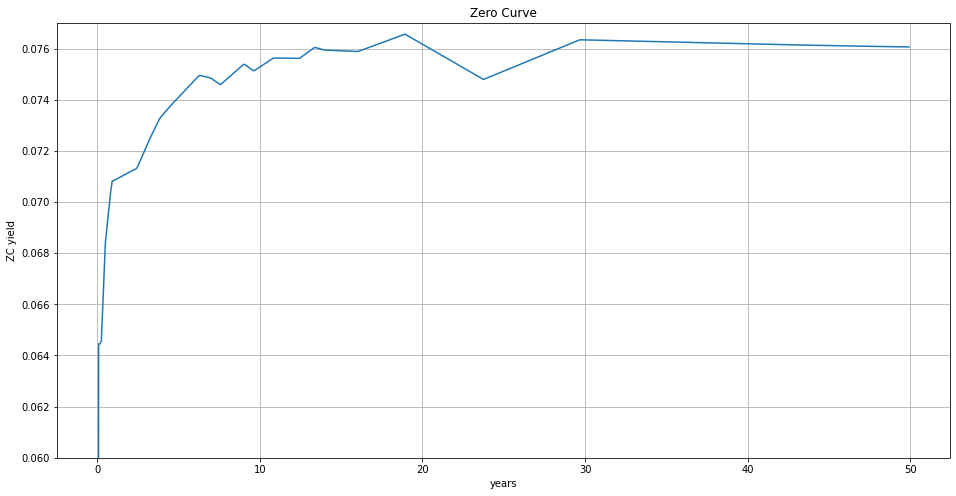

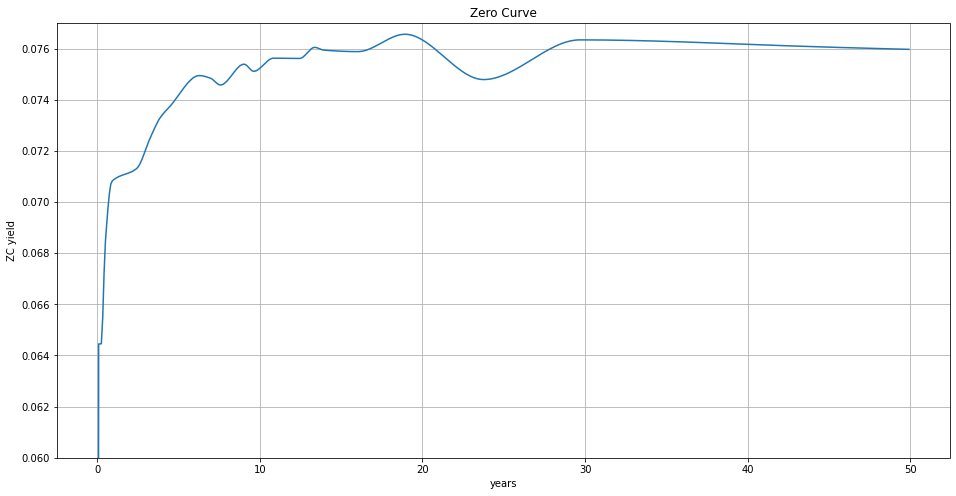

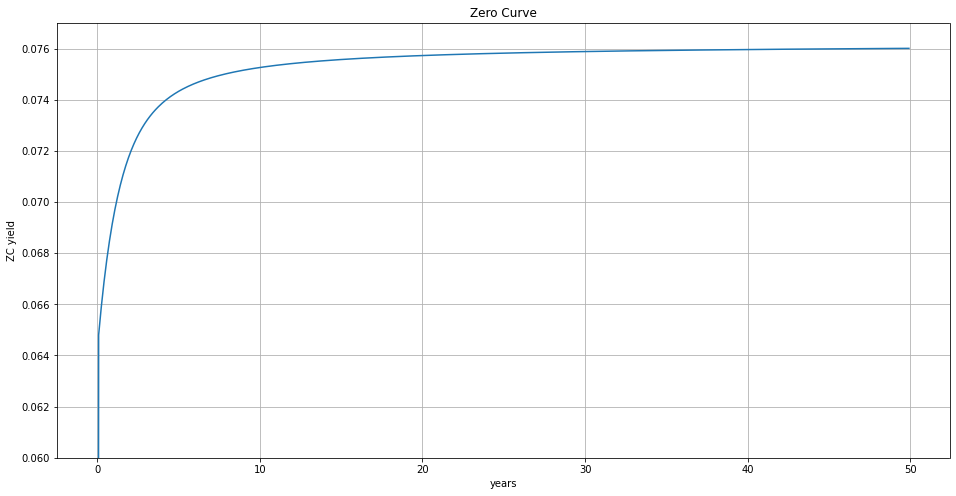

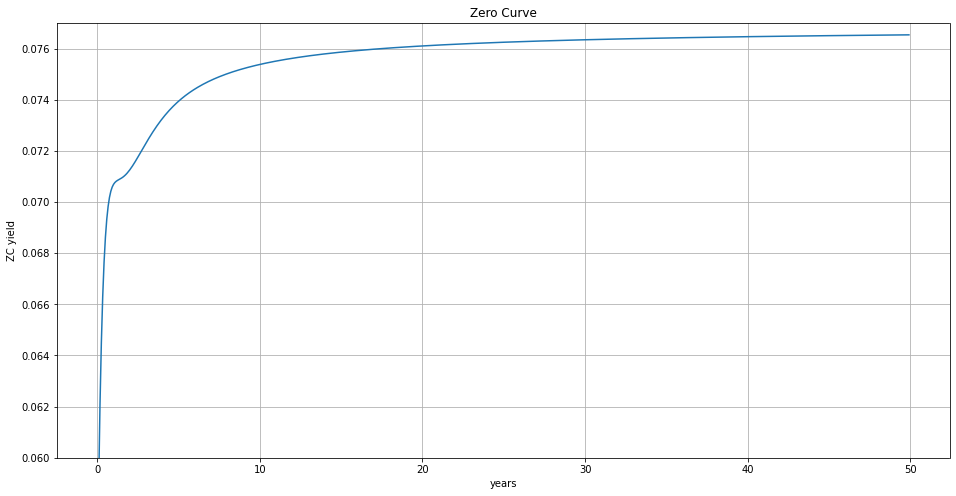

In [168]:
linear_curve = get_spot_rates(linear,dc_bond)
cubic_curve = get_spot_rates(cubic,dc_bond)
ns_curve = get_spot_rates(curve_NS,dc_bond)
nss_curve = get_spot_rates(curve_NSS,dc_bond)
curves = [linear_curve,cubic_curve,ns_curve,nss_curve]
for curve in curves:
    plt.figure(figsize=(16, 8))
    plt.ylim([0.060,0.0770])
    plt.plot(curve["Maturities"],curve["Curve"])
    plt.xlabel("years")
    plt.ylabel("ZC yield")
    plt.title('Zero Curve')
    plt.grid();